In [1]:
import pandas as pd
import numpy as np
import nltk, gensim, spacy, plotly
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import BatchNormalization, Dense, TimeDistributed, RepeatVector, Embedding, LSTM, Bidirectional, Input, Flatten, Dropout, Activation, GRU, Reshape, concatenate
from keras.models import Model 
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras import regularizers
from sklearn.metrics import confusion_matrix
import re
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
sns.set()

[nltk_data] Downloading package punkt to C:\Users\Arnav
[nltk_data]     shah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Arnav
[nltk_data]     shah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('fra.txt', sep='\t', header=None, names=['eng', 'fre', 'cc'])
data = data.drop(columns=['cc'])
data.to_csv('fra_without_CC.csv', index=False)

In [3]:
data.head()

,eng,fre
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


In [4]:
def remove_punctuations(x) :
    return re.sub('[!#?,.:";]', '', x)

In [5]:
data_cleaned = pd.read_csv('fra_without_CC.csv')
data_cleaned['eng'] = data_cleaned['eng'].apply(remove_punctuations)
data_cleaned['fre'] = data_cleaned['fre'].apply(remove_punctuations)

In [6]:
data_cleaned

,eng,fre
0,Go,Va
1,Hi,Salut
2,Hi,Salut
3,Run,Cours
4,Run,Courez
...,...,...
177205,Top-down economics never works said Obama The ...,« L'économie en partant du haut vers le bas ça...
177206,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
177207,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
177208,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


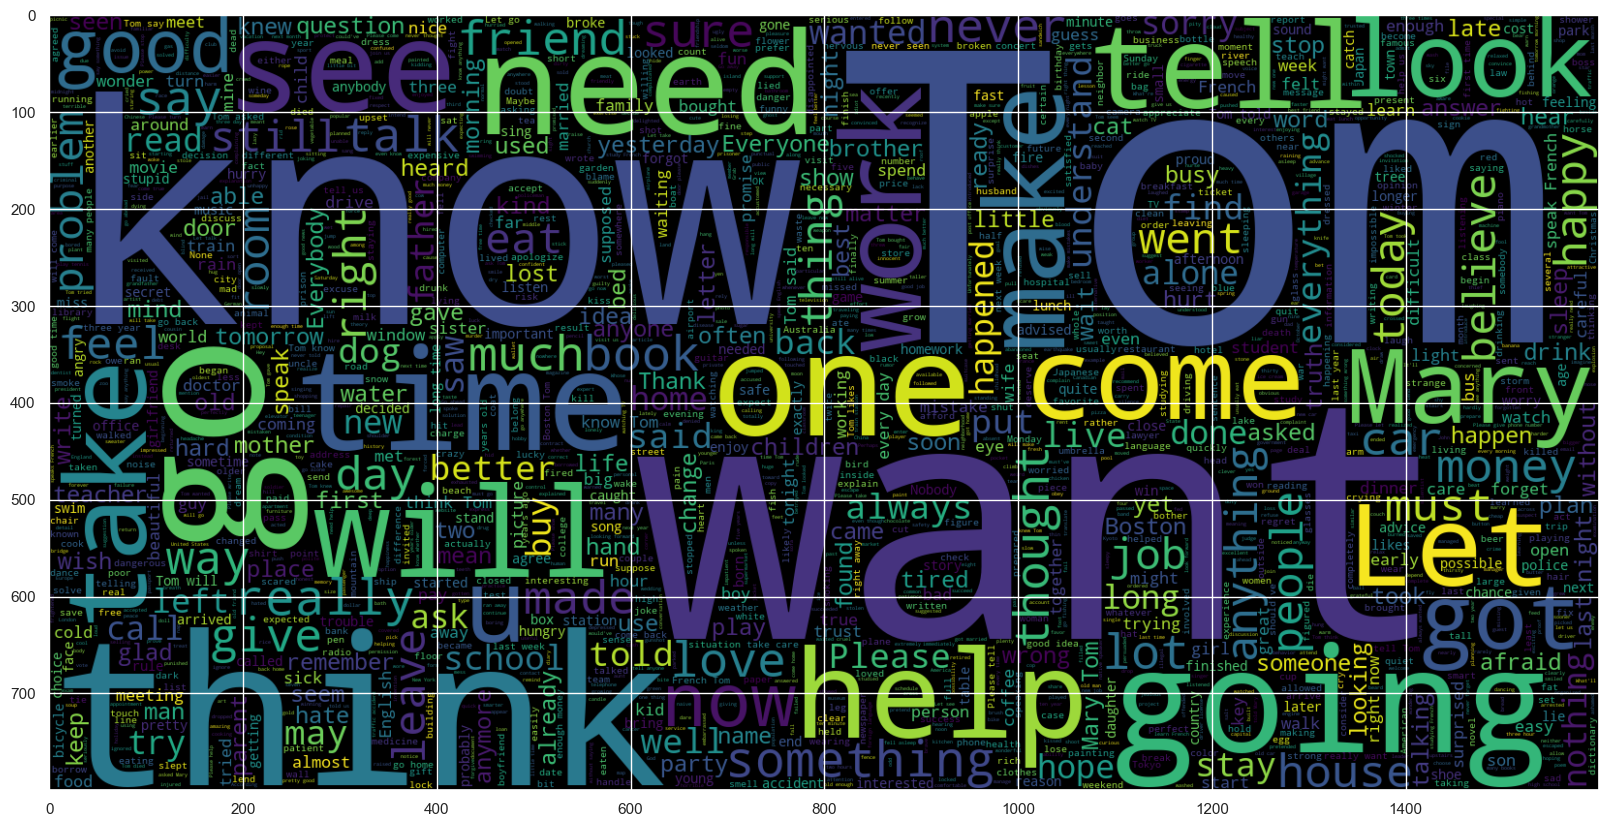

In [7]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800 ).generate(" ".join(data_cleaned.eng))
plt.imshow(wc, interpolation = 'bilinear')

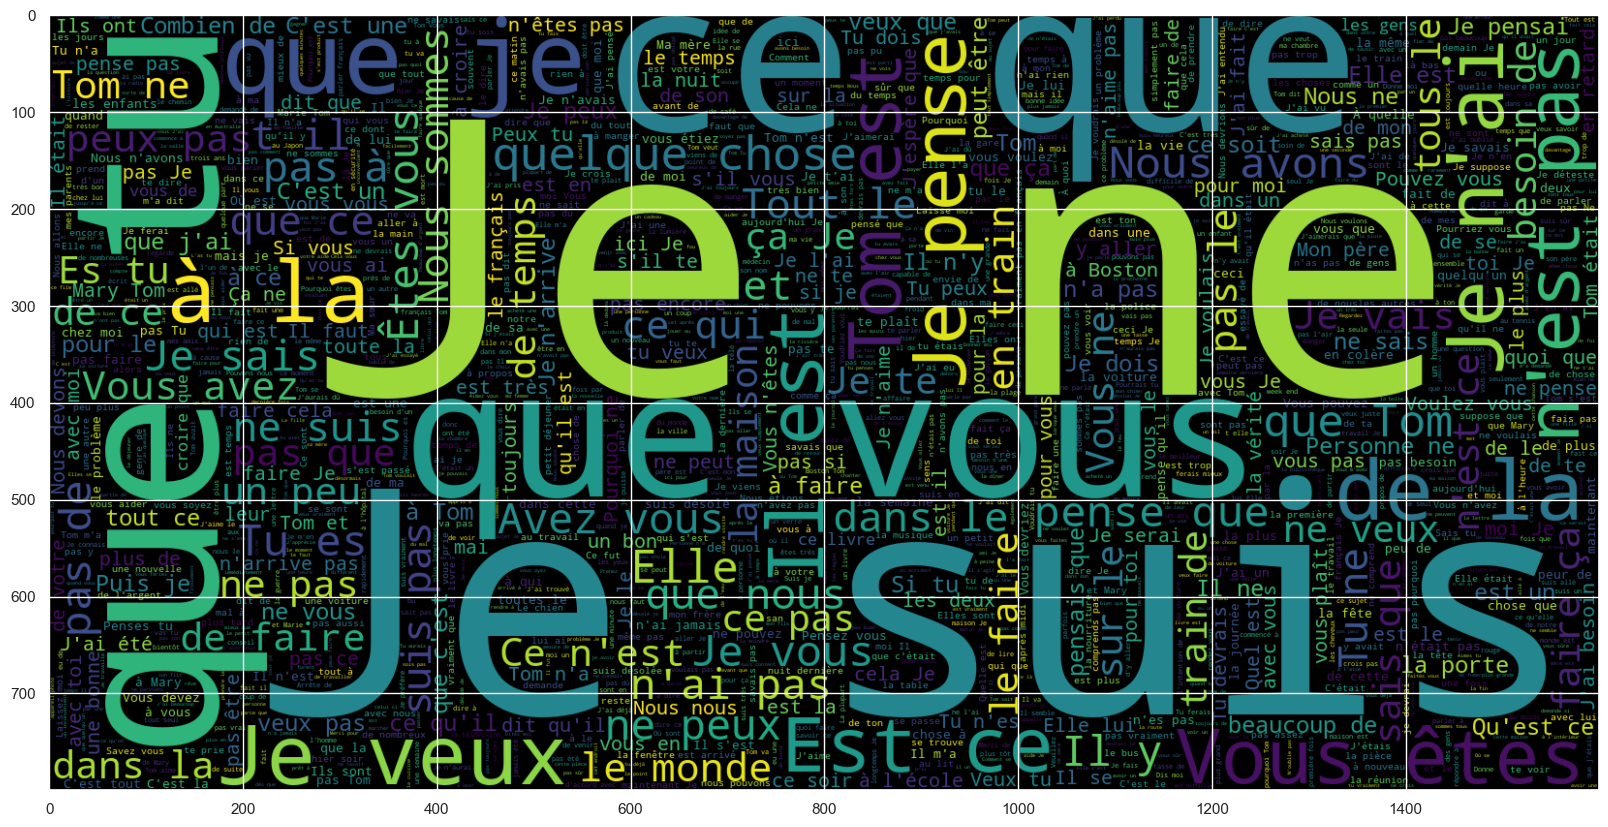

In [8]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800 ).generate(" ".join(data_cleaned.fre))
plt.imshow(wc, interpolation = 'bilinear')

In [9]:
def tokenize_and_padding_seq(x, maxlength) :
    tokenizer = Tokenizer(char_level=False)
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    padding = pad_sequences(sequences, maxlen=maxlength, padding='post')
    return tokenizer, sequences, padding

In [10]:
maxlen_english = data_cleaned['eng'].apply(lambda x: len(nltk.word_tokenize(x))).max()
maxlen_french = data_cleaned['fre'].apply(lambda x: len(nltk.word_tokenize(x))).max()

In [11]:
maxlen_french.dtype

dtype('int64')

In [12]:
X_token, X_seq, X_pad = tokenize_and_padding_seq(data_cleaned.eng, maxlen_english)
y_token, y_seq, y_pad = tokenize_and_padding_seq(data_cleaned.fre, maxlen_french)

In [13]:
def obtain_text_from_padded_vars(pad, tok) :
    k = {x : w for w, x in tok.word_index.items()}
    k[0] = ''
    return ' '.join([k[j] for j in pad])

In [14]:
obtain_text_from_padded_vars(X_pad[1], X_token)

'hi                                              '

In [15]:
obtain_text_from_padded_vars(y_pad[1], y_token)

'salut                                                      '

In [16]:
subsample_fraction = 0.2  # Adjust the fraction as needed
data_cleaned_subsampled = data_cleaned.sample(frac=subsample_fraction, random_state=42)

In [17]:
from sklearn.model_selection import train_test_split
X_subsampled = pad_sequences(X_token.texts_to_sequences(data_cleaned['eng']), maxlen=maxlen_english, padding='post')
y_subsampled = pad_sequences(y_token.texts_to_sequences(data_cleaned['fre']), maxlen=maxlen_french, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X_subsampled, y_subsampled, test_size=0.2, random_state=42)

In [18]:
batch_size = 128 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

In [19]:
english_vocab_size = len(X_token.word_index) + 1
french_vocab_size = len(y_token.word_index) + 1

In [20]:
strategy = tf.distribute.experimental.CentralStorageStrategy()
with strategy.scope():  
    model = Sequential()

    model.add(Embedding(english_vocab_size, 256, input_length=maxlen_english, mask_zero=True))

    model.add(Bidirectional(LSTM(256, return_sequences=False)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(RepeatVector(int(maxlen_french)))

    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
    model.add(BatchNormalization())

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

INFO:tensorflow:ParameterServerStrategy (CentralStorageStrategy if you are using a single machine) with compute_devices = ['/job:localhost/replica:0/task:0/device:CPU:0'], variable_device = '/job:localhost/replica:0/task:0/device:CPU:0'
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 47, 256)           3757056   
                                                                 
 bidirectional (Bidirection  (None, 512)               1050624   
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                 

In [21]:
y_train = np.expand_dims(y_train, axis=2)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
mo = model.fit(train_dataset, epochs=30, validation_data=test_dataset, callbacks=[early_stopping])

Epoch 1/30
1108/1108 [==============================] - 10925s 10s/step - loss: 1.6470 - accuracy: 0.8747 - val_loss: 1.8760 - val_accuracy: 0.8437
Epoch 2/30
 134/1108 [==>...........................] - ETA: 2:31:35 - loss: 1.5339 - accuracy: 0.8810

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mo.history['accuracy'], label='Training Accuracy')
plt.plot(mo.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(mo.history['loss'], label='Training Loss')
plt.plot(mo.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()

In [ ]:
pred = model.predict(X_test)
correct_predictions = np.sum(np.argmax(pred, axis=-1) == np.argmax(y_test, axis=-1))
total_samples = len(y_test)
accuracy = correct_predictions/total_samples

In [ ]:
def prediction(x, x_tok = X_token, y_tok = y_token):
    predictions = model.predict(x)[0]
    id_to_word = {id: word for word, id in y_token.word_index.items()}
    id_to_word[0] = ''
    return ' '.join([id_to_word[j] for j in np.argmax(predictions,1)])

In [ ]:
for p in range(10):
    print('Original English word: ', obtain_text_from_padded_vars(X_test[p], X_token))
    print('Original French word: ', obtain_text_from_padded_vars(y_test[p], y_token))
    print('Predicted French word: ', prediction(np.expand_dims(X_test[p], axis=0)))
    print()